In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import numpy as np, random

In [2]:
class PairMNIST(Dataset):
    def __init__(self, mnist_subset):
        self.data = mnist_subset.dataset.data[mnist_subset.indices]
        self.targets = mnist_subset.dataset.targets[mnist_subset.indices]
        self.transform = transforms.ToTensor()
        
        # Organize indices by label
        self.index_by_label = {i: (self.targets == i).nonzero(as_tuple=True)[0].tolist() for i in range(10)}

        # Generate pairs
        self.pairs, self.labels = [], []
        for idx in range(len(self.data)):
            img1_label = int(self.targets[idx])

            # Ensure positive pair has the same label
            pos_idx = random.choice(self.index_by_label[img1_label])
            self.pairs.append((idx, pos_idx))
            self.labels.append(1)  # Same digit

            # Ensure negative pair has a different label
            neg_label = random.choice([l for l in range(10) if l != img1_label])
            neg_idx = random.choice(self.index_by_label[neg_label])
            self.pairs.append((idx, neg_idx))
            self.labels.append(0)  # Different digit

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        i1, i2 = self.pairs[idx]
        img1 = self.transform(self.data[i1].numpy()).squeeze(0) 
        img2 = self.transform(self.data[i2].numpy()).squeeze(0)
    
        # Stack images to form a (2, 28, 28) tensor
        pair = torch.stack([img1, img2], dim=0)  # Now correctly (2, 28, 28)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        
        return pair, label

In [3]:
# Load full MNIST dataset
train_full = MNIST(root='./data', train=True, download=True)
test_full = MNIST(root='./data', train=False, download=True)

# Ensure no overlap by taking distinct subsets within each dataset
num_train_samples = int(0.1 * len(train_full)) 
num_test_samples = int(0.1 * len(test_full))   

# Randomly select indices **without replacement** from each dataset separately
train_indices = np.random.choice(len(train_full), num_train_samples, replace=False)
test_indices = np.random.choice(len(test_full), num_test_samples, replace=False)

# Create subsets
train_subset = Subset(train_full, train_indices)
test_subset = Subset(test_full, test_indices)

# Custom dataset for paired MNIST
train_dataset = PairMNIST(train_subset)
test_dataset = PairMNIST(test_subset)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.1MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 475kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.45MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.80MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



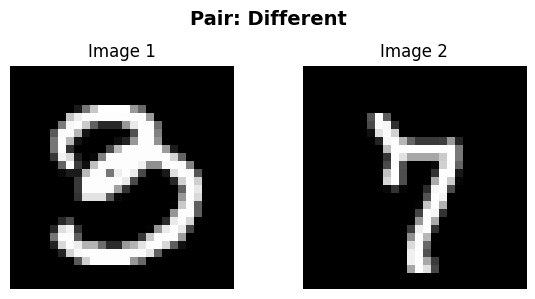

In [4]:
import matplotlib.pyplot as plt
import torch

# Get a batch of data
data_iter = iter(train_loader)
pairs, labels = next(data_iter)

# Move tensors to CPU and convert them to NumPy
pairs = pairs.cpu().detach().numpy()  # Shape: (batch_size, 2, 28, 28)
labels = labels.cpu().detach().numpy()

# Select the first pair
img1 = pairs[0, 0, :, :]  # First image
img2 = pairs[0, 1, :, :]  # Second image
label = labels[0]  # Label (1 = same digit, 0 = different)

# Create a single row of images
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
fig.suptitle(f"Pair: {'Same' if label == 1 else 'Different'}", fontsize=14, fontweight='bold')

# Image 1
axes[0].imshow(img1.squeeze(), cmap='gray')
axes[0].set_title("Image 1")
axes[0].axis("off")

# Image 2
axes[1].imshow(img2.squeeze(), cmap='gray')
axes[1].set_title("Image 2")
axes[1].axis("off")

plt.tight_layout()
plt.show()

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SiameseCNN(nn.Module):
    def __init__(self):
        super(SiameseCNN, self).__init__()
        
        # Shared CNN Feature Extractor
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # (28, 28) → (28, 28)
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # (28, 28) → (28, 28)
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),  # (28, 28) → (14, 14)
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # (14, 14) → (14, 14)
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),  # (14, 14) → (7, 7)

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # (7, 7) → (7, 7)
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2, 2)  # (7, 7) → (3, 3)
        )
        
        # Fully Connected Embedding Layer
        self.fc = nn.Sequential(
            nn.Linear(256 * 3 * 3, 512), 
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256)
        )
        
        # Final Binary Classification
        self.classifier = nn.Sequential(
            nn.Linear(768, 256),  # Fix: Match input size
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
        
    def forward_once(self, x):
        """Passes one input through the shared feature extractor."""
        x = self.conv(x)
        x = x.view(x.shape[0], -1)  # Flatten
        x = self.fc(x)
        return x

    def forward(self, x):
        """Takes in (batch_size, 2, 28, 28) and processes both images."""
        
        # Extract image pairs (x is [batch_size, 2, 28, 28])
        img1 = x[:, 0].unsqueeze(1)  # Converts (batch_size, 28, 28) → (batch_size, 1, 28, 28)
        img2 = x[:, 1].unsqueeze(1)  # Same for img2
    
        # Ensure correct shape for Conv2D
        assert img1.shape == (x.shape[0], 1, 28, 28), f"Shape error: {img1.shape}"
        assert img2.shape == (x.shape[0], 1, 28, 28), f"Shape error: {img2.shape}"
    
        # Pass through shared CNN
        feat1 = self.forward_once(img1)  # Shape: (batch_size, 256)
        feat2 = self.forward_once(img2)  # Shape: (batch_size, 256
        
        # Fix merging of features
        merged = torch.cat([feat1, feat2, torch.abs(feat1 - feat2)], dim=1)  # Shape: (batch_size, 768)
    
        # Final classifier
        out = self.classifier(merged)  # Shape: (batch_size, 1)
        
        return out

In [6]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize model and move to GPU
model = SiameseCNN().to(device)

# Loss function and optimizer
criterion = nn.BCELoss()  # Binary classification loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

Using device: cuda


In [7]:
num_epochs = 20  # Adjust based on performance
train_loss = []
test_loss = []

for epoch in range(num_epochs):
    ### 🔥 TRAINING PHASE ###
    model.train()  # Set model to training mode
    running_loss = 0.0

    for pairs, labels in train_loader:
        pairs, labels = pairs.to(device), labels.to(device)  # Move batch to GPU

        optimizer.zero_grad()  # Reset gradients
        outputs = model(pairs).squeeze()  # Forward pass

        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_loss.append(avg_train_loss)
    scheduler.step()

    ### 🎯 EVALUATION PHASE ###
    model.eval()  # Set model to evaluation mode
    correct, total = 0, 0
    running_val_loss = 0.0

    with torch.no_grad():  # No need to track gradients during evaluation
        for pairs, labels in test_loader:
            pairs, labels = pairs.to(device), labels.to(device)

            outputs = model(pairs).squeeze()
            val_loss = criterion(outputs, labels)  # Compute validation loss
            running_val_loss += val_loss.item()

            predictions = (outputs > 0.5).float()  # Convert probs to 0 or 1
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = running_val_loss / len(test_loader)
    test_loss.append(avg_val_loss)
    accuracy = correct / total * 100  # Compute accuracy

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {accuracy:.2f}%")

print("Training complete!")

Epoch [1/20] | Train Loss: 0.2632 | Val Loss: 0.1363 | Val Acc: 95.25%
Epoch [2/20] | Train Loss: 0.0693 | Val Loss: 0.6577 | Val Acc: 91.40%
Epoch [3/20] | Train Loss: 0.0392 | Val Loss: 0.0766 | Val Acc: 97.90%
Epoch [4/20] | Train Loss: 0.0192 | Val Loss: 0.0856 | Val Acc: 97.90%
Epoch [5/20] | Train Loss: 0.0228 | Val Loss: 0.0617 | Val Acc: 98.50%
Epoch [6/20] | Train Loss: 0.0060 | Val Loss: 0.0249 | Val Acc: 99.25%
Epoch [7/20] | Train Loss: 0.0021 | Val Loss: 0.0364 | Val Acc: 98.85%
Epoch [8/20] | Train Loss: 0.0008 | Val Loss: 0.0331 | Val Acc: 98.95%
Epoch [9/20] | Train Loss: 0.0007 | Val Loss: 0.0360 | Val Acc: 99.15%
Epoch [10/20] | Train Loss: 0.0004 | Val Loss: 0.0371 | Val Acc: 98.90%
Epoch [11/20] | Train Loss: 0.0003 | Val Loss: 0.0324 | Val Acc: 99.10%
Epoch [12/20] | Train Loss: 0.0004 | Val Loss: 0.0327 | Val Acc: 99.05%
Epoch [13/20] | Train Loss: 0.0014 | Val Loss: 0.0340 | Val Acc: 98.90%
Epoch [14/20] | Train Loss: 0.0003 | Val Loss: 0.0348 | Val Acc: 99.00%
E

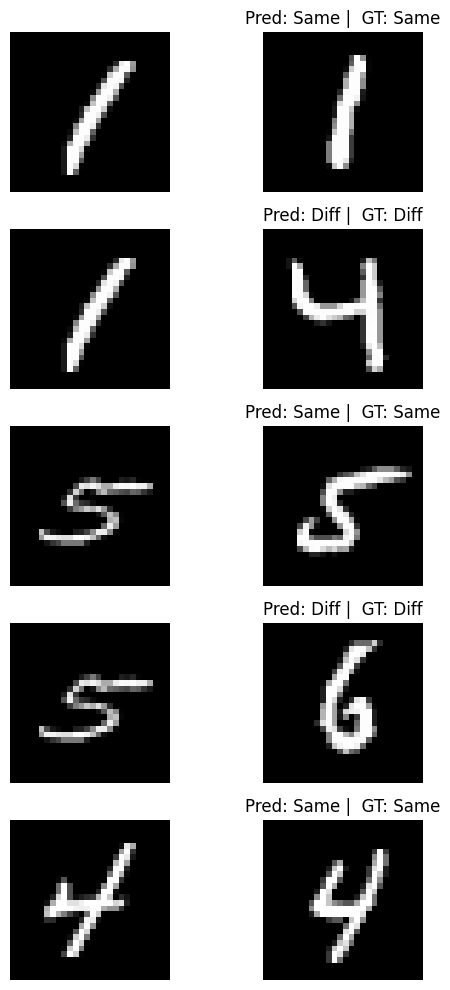

In [8]:
import torch
import matplotlib.pyplot as plt

# Set model to evaluation mode
model.eval()

# Get a batch from the test loader
data_iter = iter(test_loader)
pairs, labels = next(data_iter)

# Move to the same device as model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pairs, labels = pairs.to(device), labels.to(device)

# Get predictions
with torch.no_grad():
    outputs = model(pairs).squeeze()  # Shape: (batch_size,)
    predictions = (outputs > 0.5).float()  # Convert probabilities to binary 0/1

# Move tensors to CPU for visualization
pairs, labels, predictions = pairs.cpu(), labels.cpu(), predictions.cpu()

# Display 5 random test pairs
num_samples = 5
fig, axes = plt.subplots(num_samples, 2, figsize=(6, 10))

for i in range(num_samples):
    img1 = pairs[i, 0].numpy()  # First image in pair
    img2 = pairs[i, 1].numpy()  # Second image in pair
    label = int(labels[i])  # Ground truth
    pred = int(predictions[i])  # Model prediction

    # Image 1
    axes[i, 0].imshow(img1.squeeze(), cmap='gray')
    axes[i, 0].axis("off")

    # Image 2
    axes[i, 1].imshow(img2.squeeze(), cmap='gray')
    axes[i, 1].set_title(f"Pred: {'Same' if pred == 1 else 'Diff'} |  GT: {'Same' if label == 1 else 'Diff'}")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()

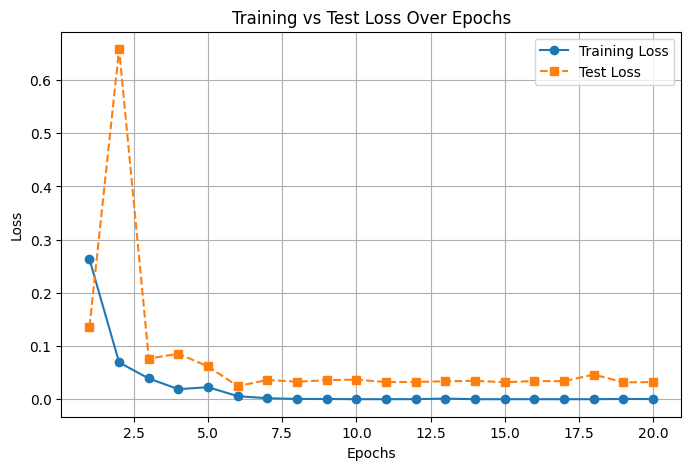

In [9]:
import matplotlib.pyplot as plt

# Number of epochs
epochs = list(range(1, len(train_loss) + 1))

# Plot training and test loss
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, label="Training Loss", marker='o', linestyle='-')
plt.plot(epochs, test_loss, label="Test Loss", marker='s', linestyle='--')

# Labels and title
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Test Loss Over Epochs")
plt.legend()
plt.grid(True)

# Show plot
plt.show()

In [10]:
from sklearn.metrics import precision_score, recall_score, f1_score

def compute_metrics(model, dataloader, device):
    model.eval()
    all_labels, all_preds = [], []

    with torch.no_grad():
        for pairs, labels in dataloader:
            pairs, labels = pairs.to(device), labels.to(device)
            outputs = model(pairs).squeeze()
            predictions = (outputs > 0.5).float()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predictions.cpu().numpy())

    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    return precision, recall, f1

precision, recall, f1 = compute_metrics(model, test_loader, device)
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

Precision: 0.9970, Recall: 0.9870, F1-Score: 0.9920


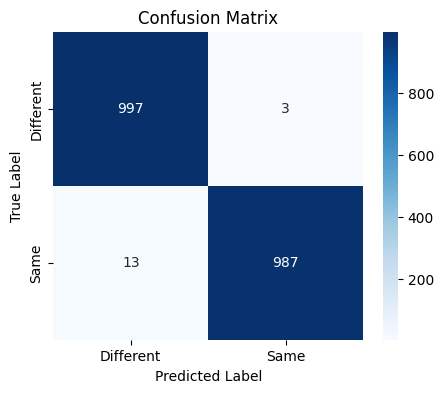

In [11]:
import seaborn as sns
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, dataloader, device):
    model.eval()
    all_labels, all_preds = [], []

    with torch.no_grad():
        for pairs, labels in dataloader:
            pairs, labels = pairs.to(device), labels.to(device)
            outputs = model(pairs).squeeze()
            predictions = (outputs > 0.5).float()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predictions.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot the confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Different", "Same"], yticklabels=["Different", "Same"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()


plot_confusion_matrix(model, test_loader, device)